In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In this notebook, we’ll explore the renowned “House Prices – Advanced Regression Techniques” dataset. We’ll start with a thorough EDA, then preprocess the data, fit a baseline model, and finally refine it using cross-validation.

In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.stats
from math import sqrt 
from sklearn.model_selection import KFold, cross_val_score
import optuna
from xgboost import XGBRegressor 
from catboost import CatBoostRegressor 
import pandas as pd 
import warnings
import numpy as np

warnings.filterwarnings('ignore')

pd.pandas.set_option('display.max_columns',None)

In [3]:
df_train=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
sample_submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

## EDA

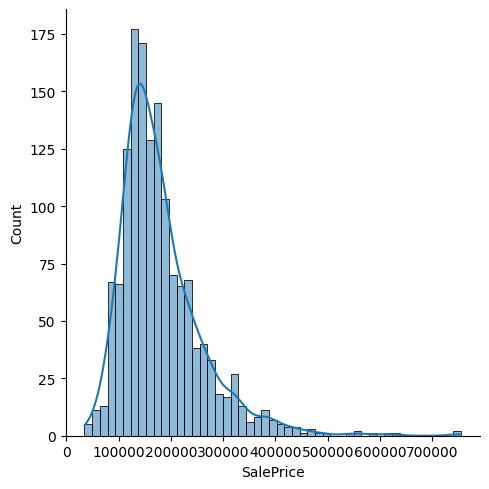

In [4]:
# Distribution of values in target feature
sns.displot(df_train.get("SalePrice"), kde=True)

The target feature **SalePrice** is right-skewed, we should perform a log-normal transformation on his feature.

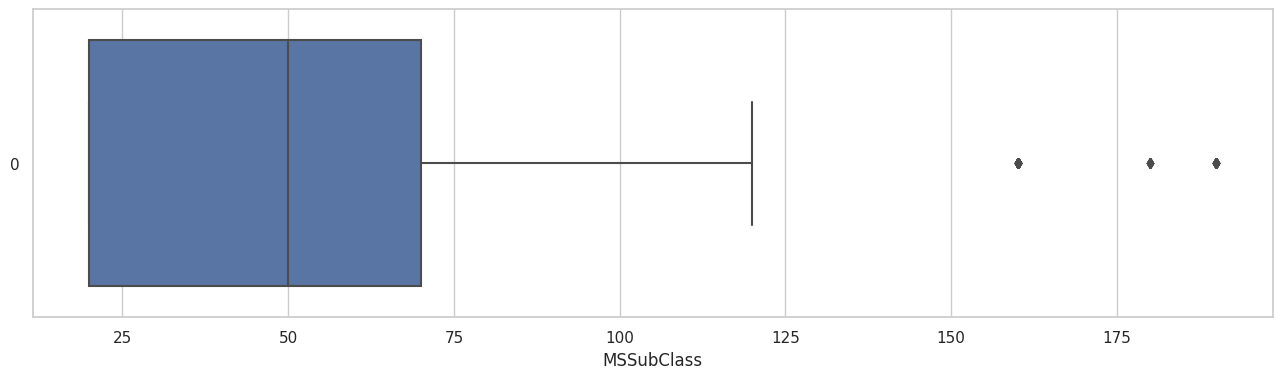

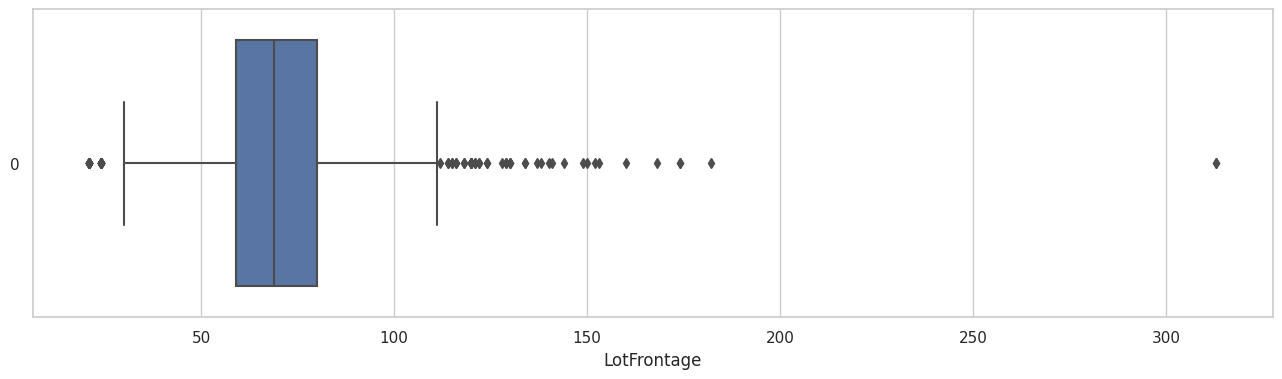

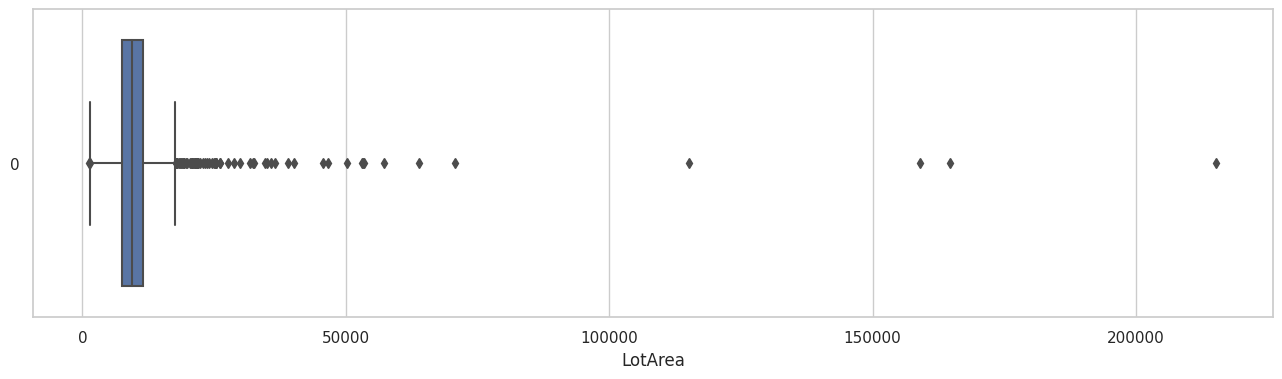

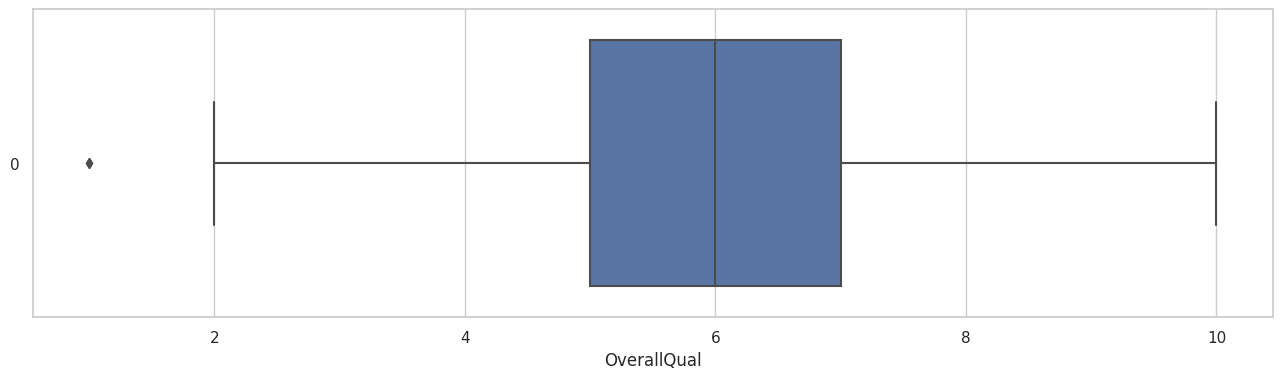

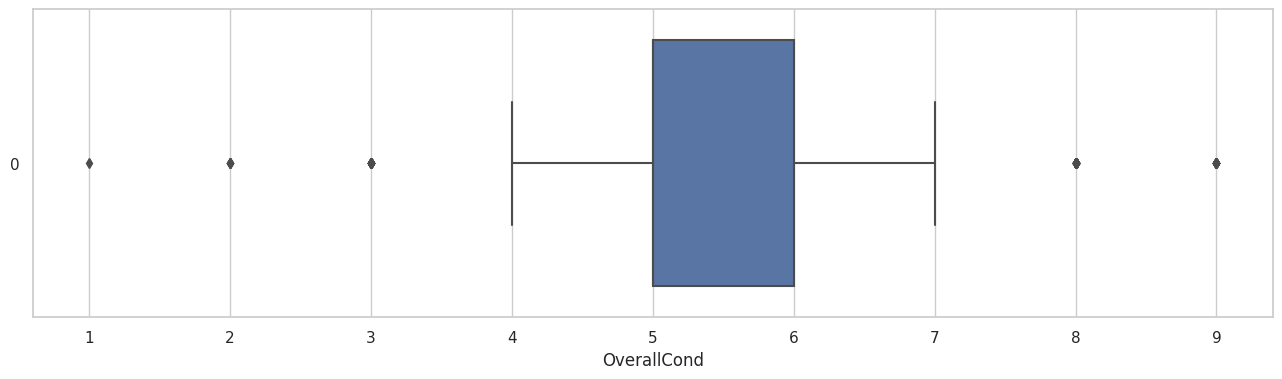

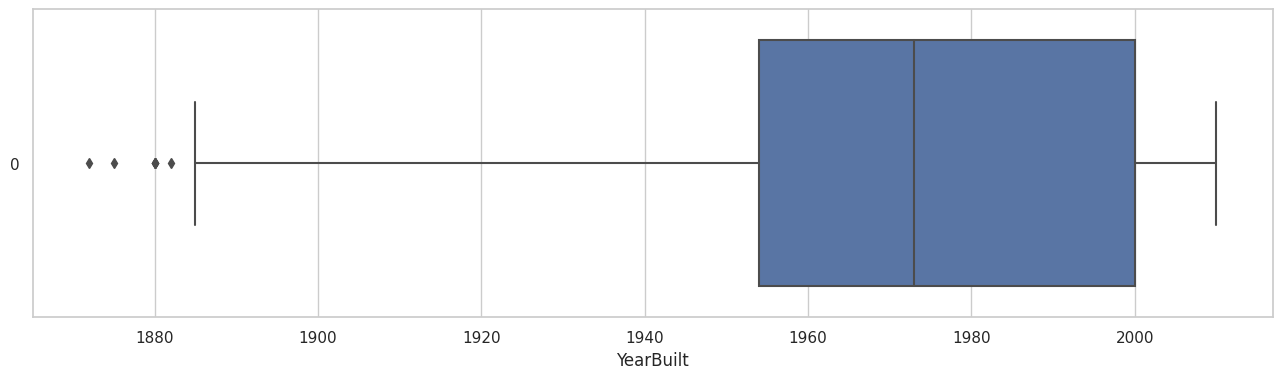

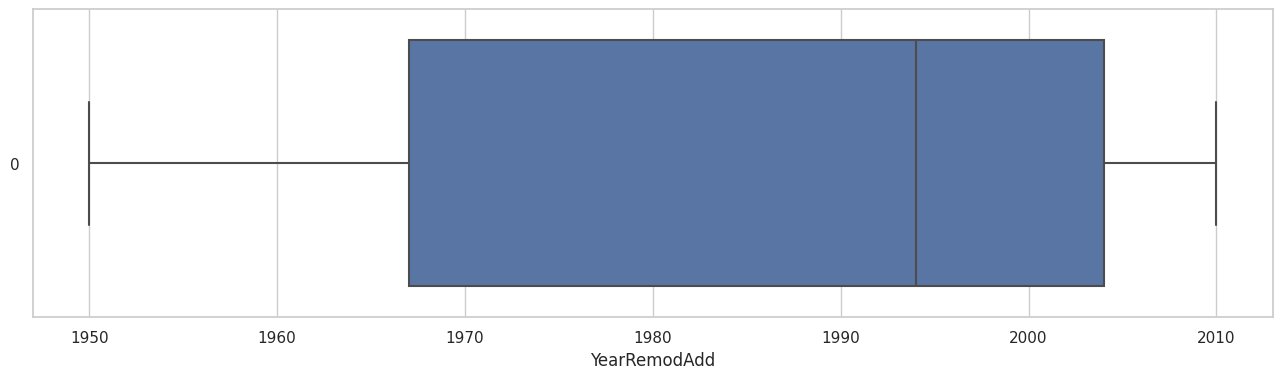

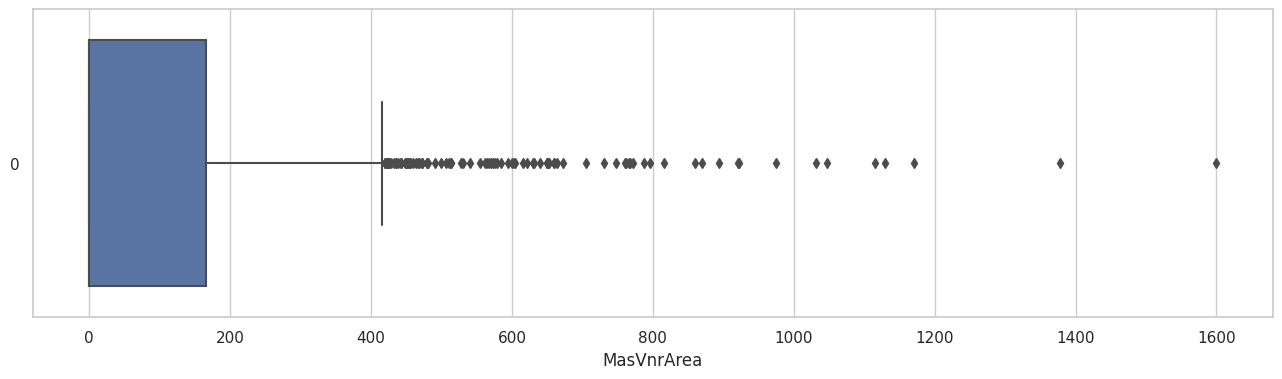

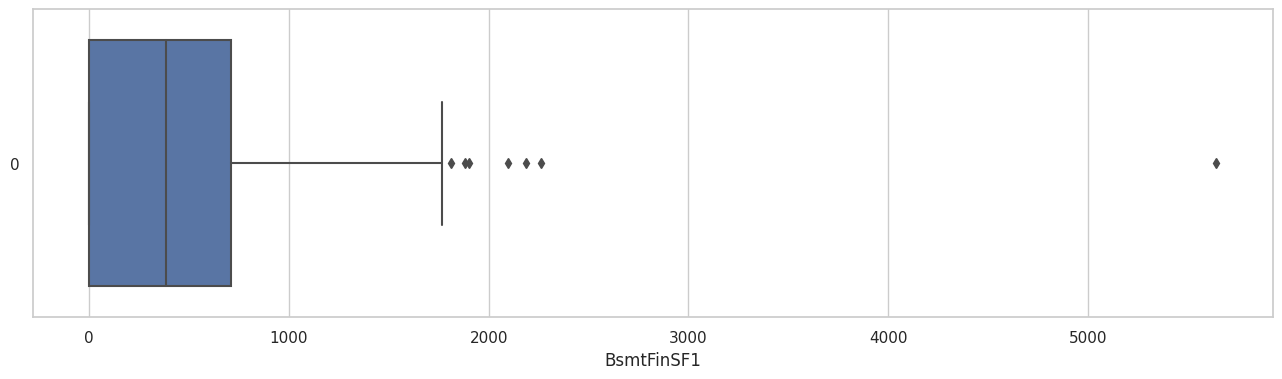

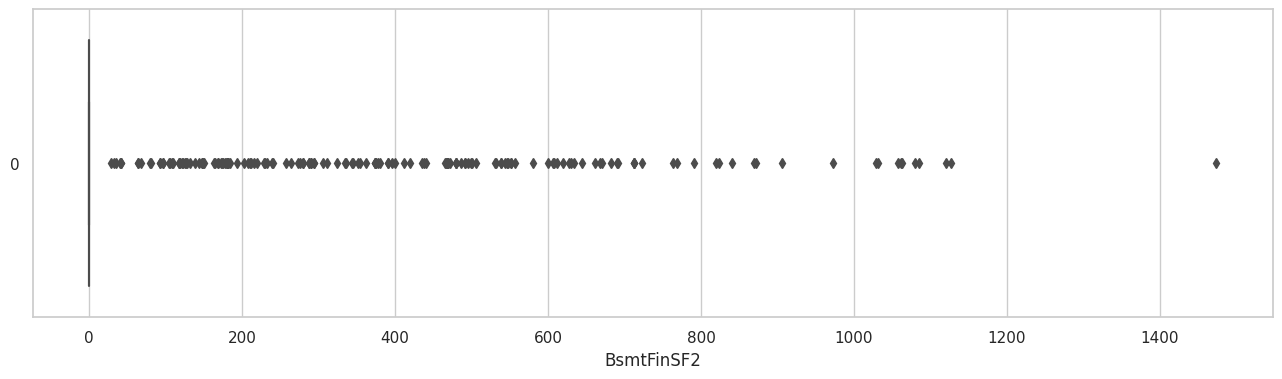

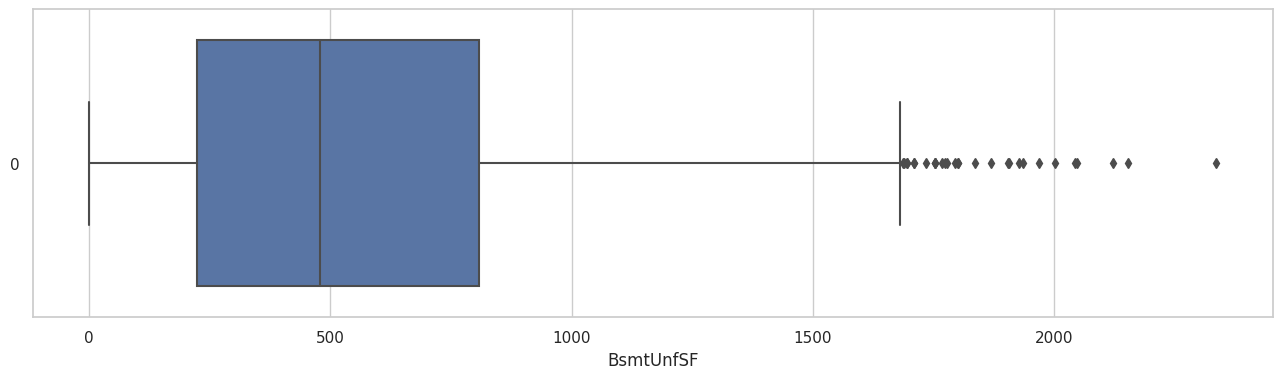

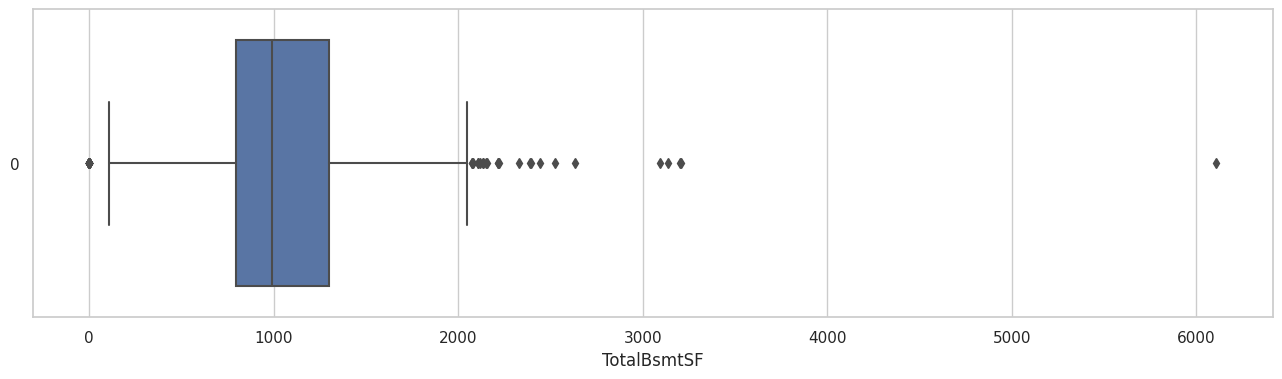

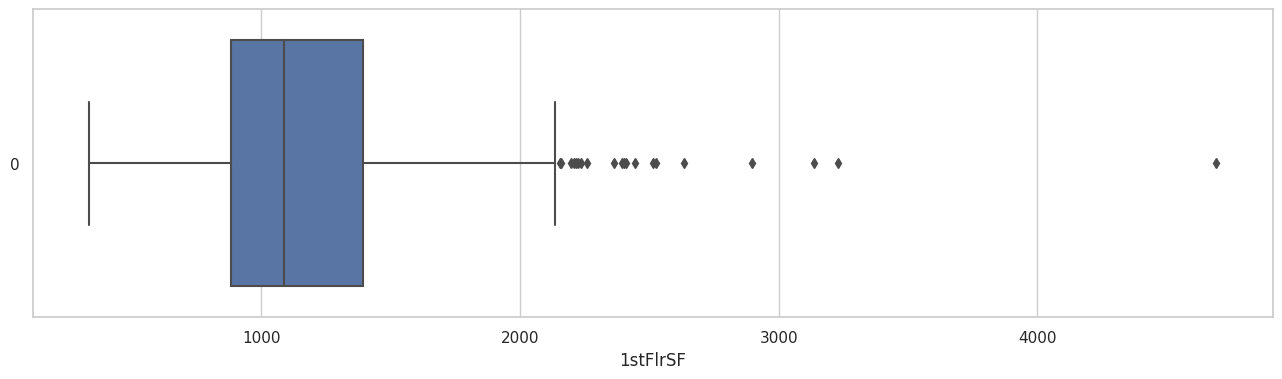

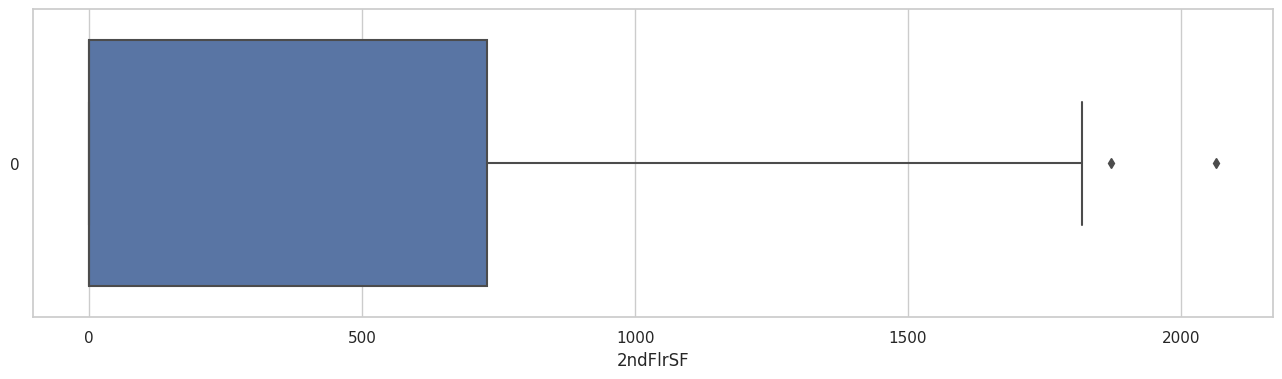

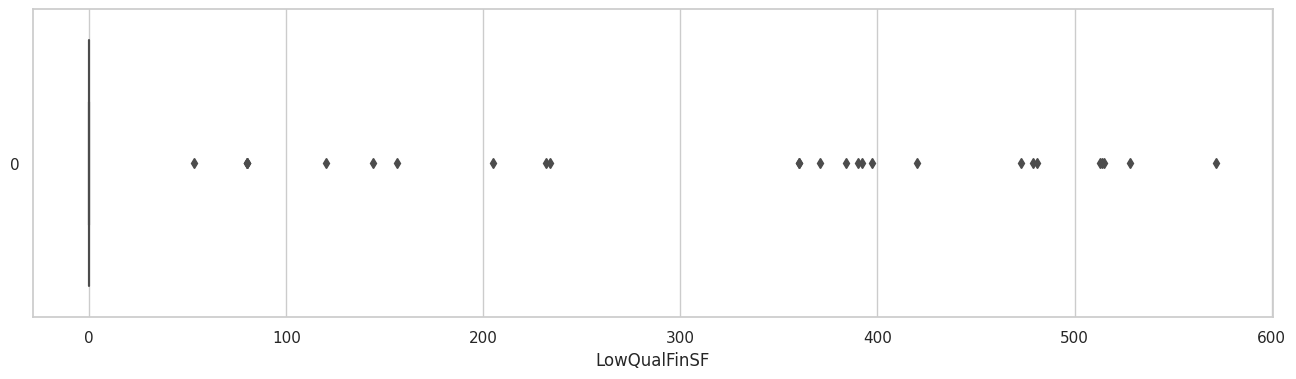

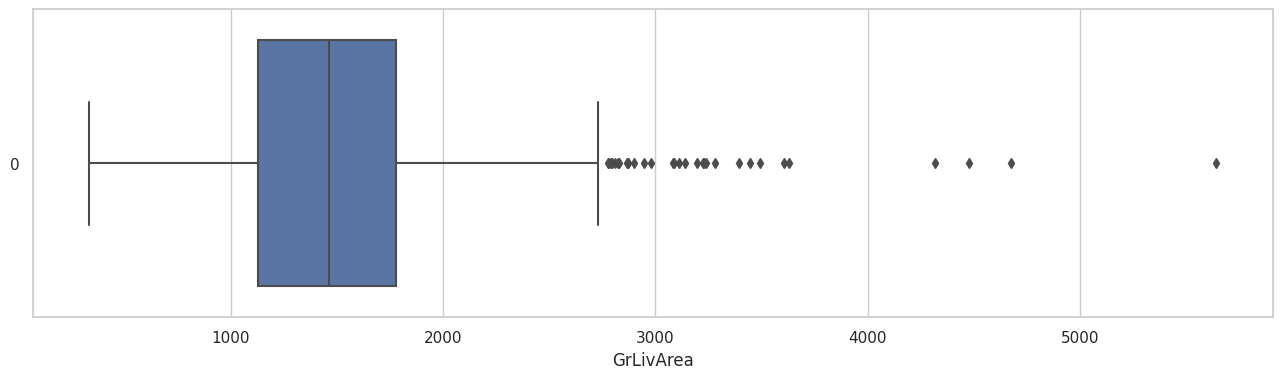

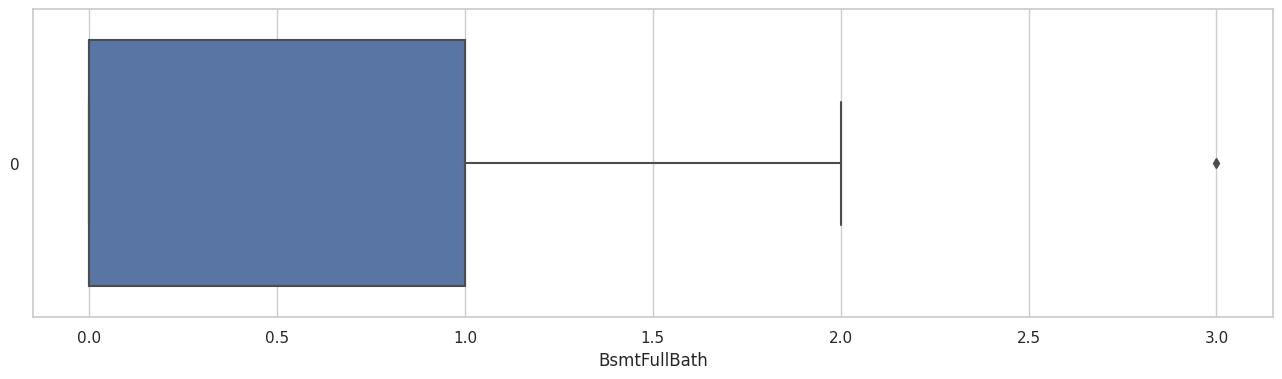

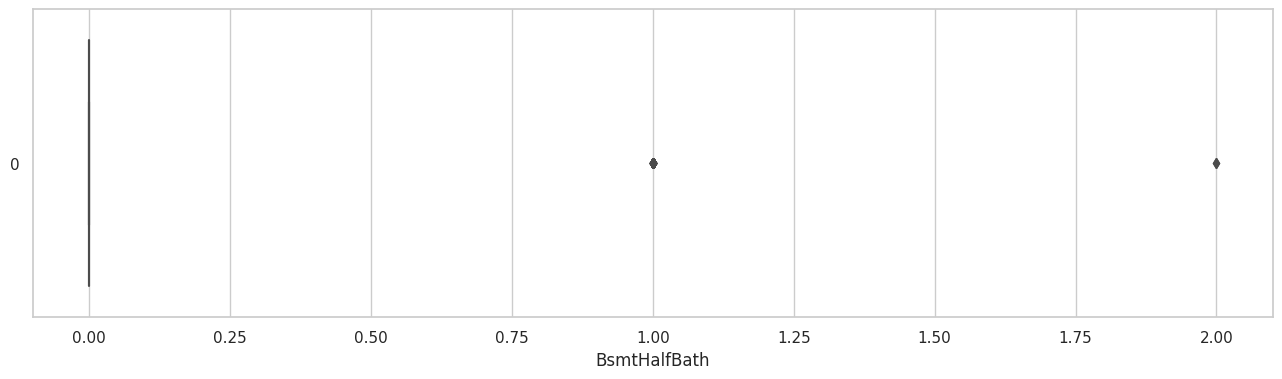

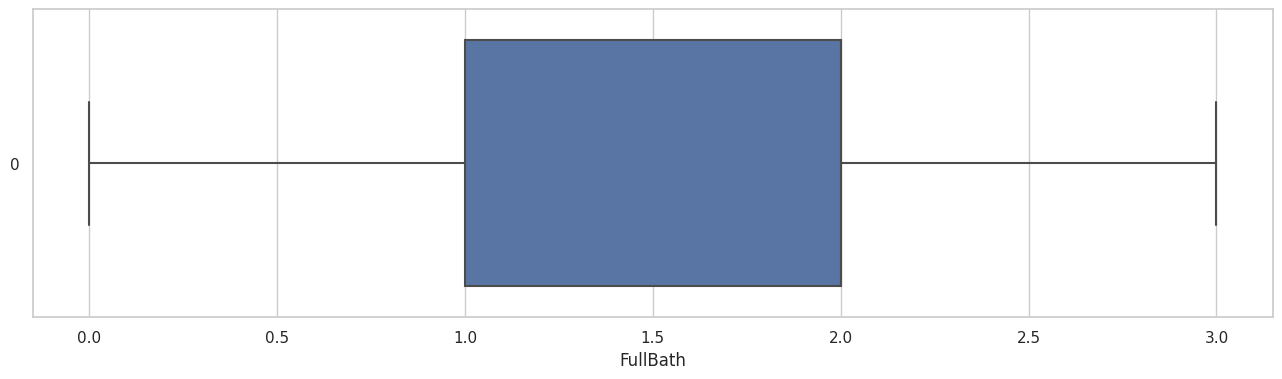

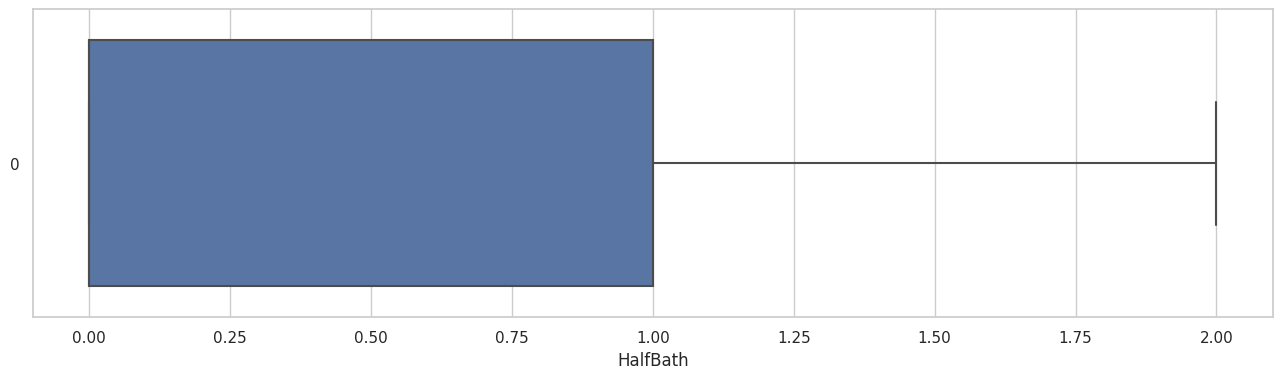

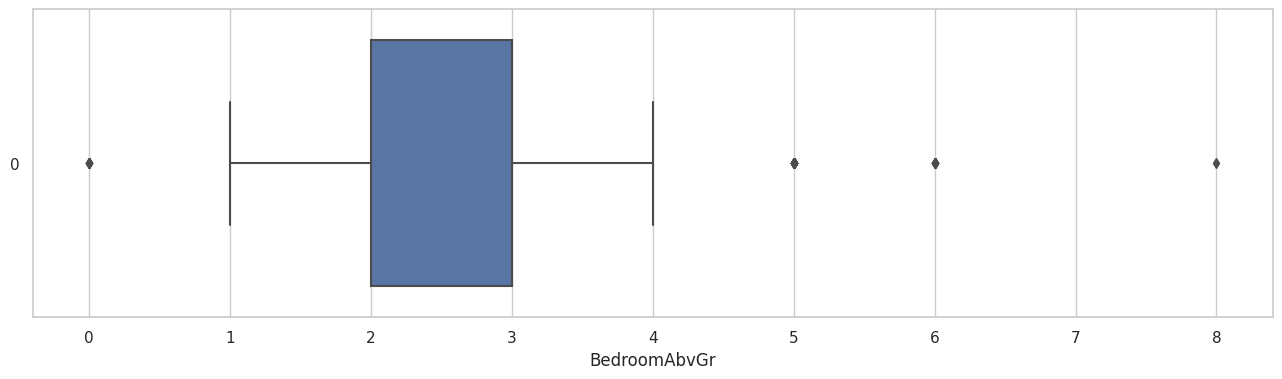

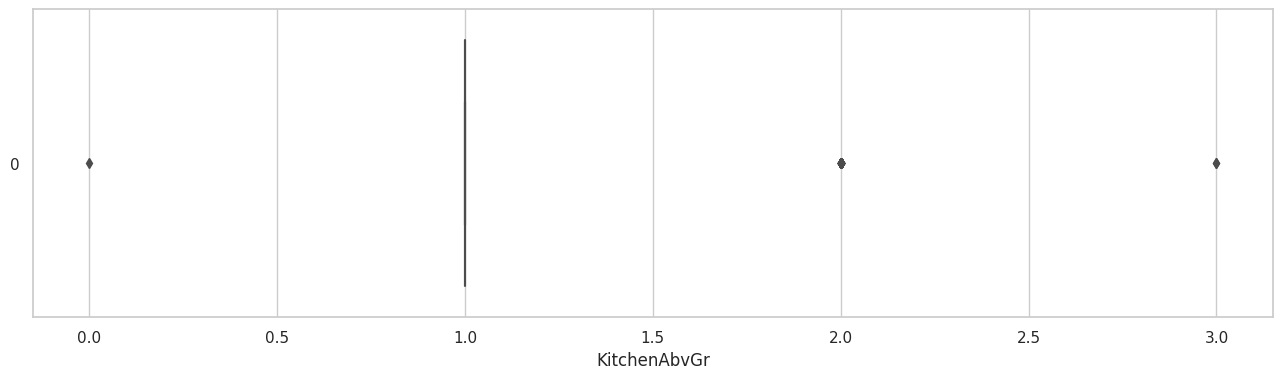

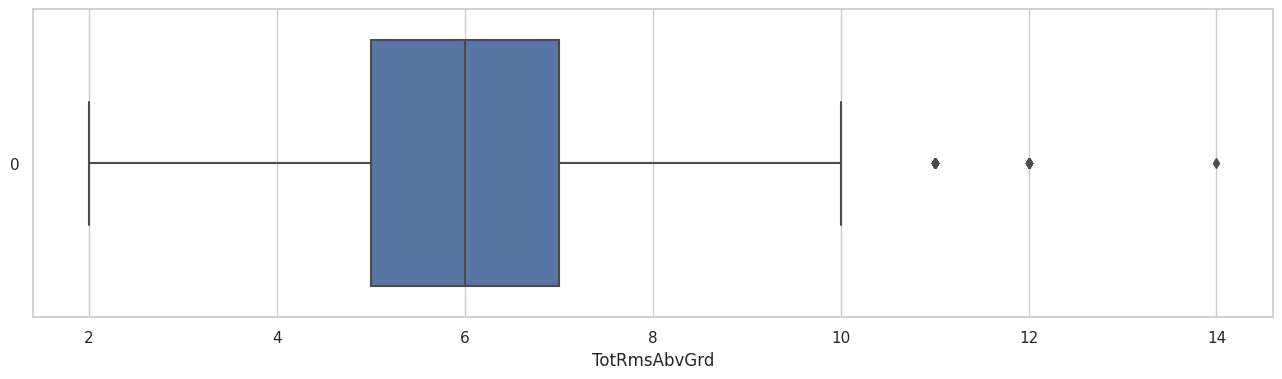

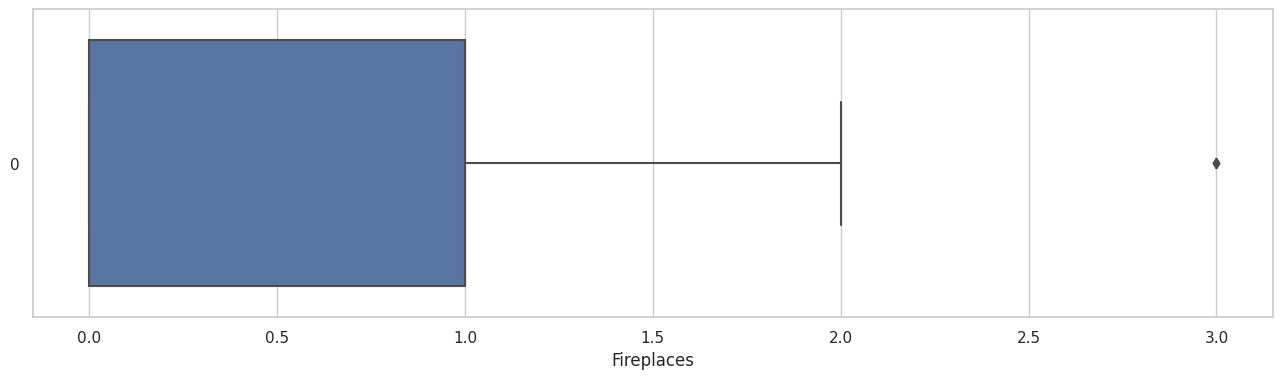

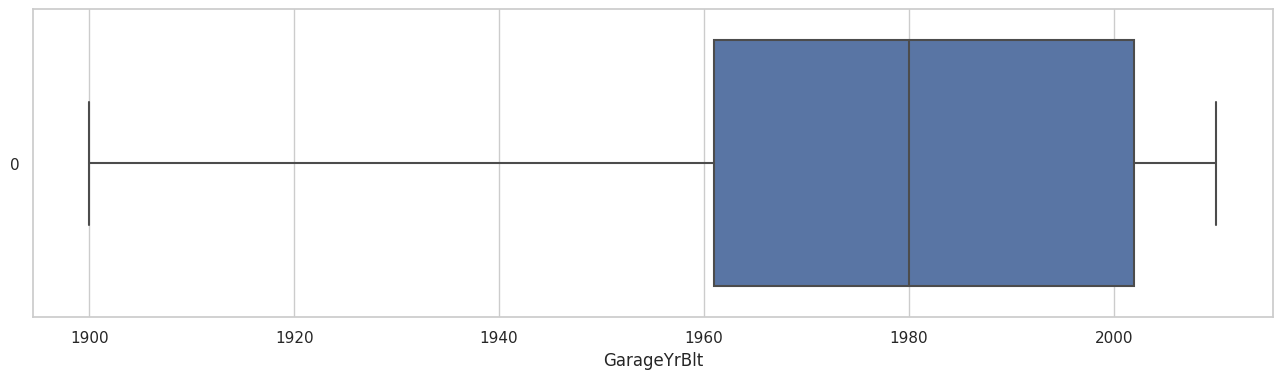

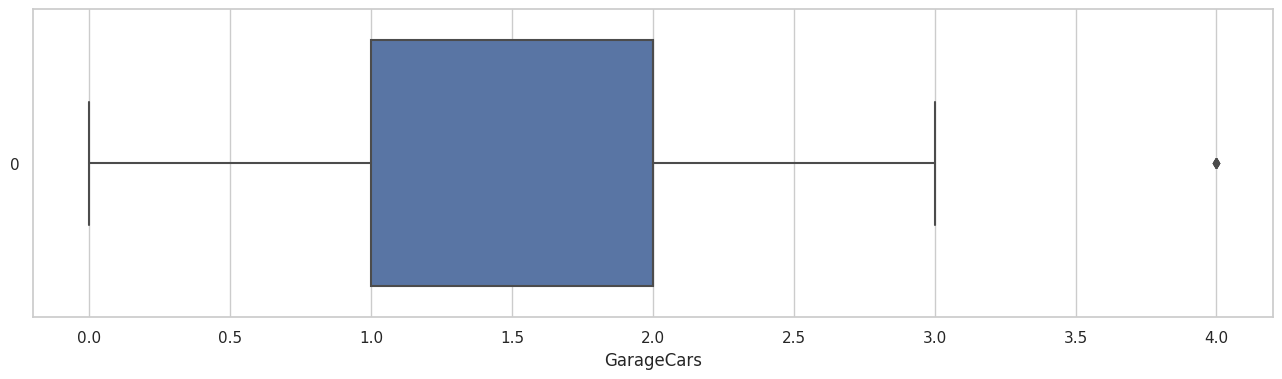

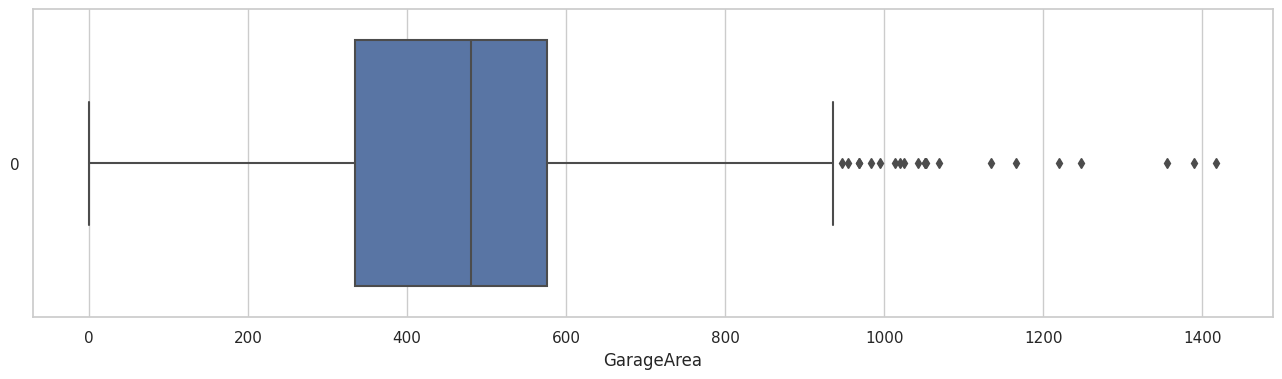

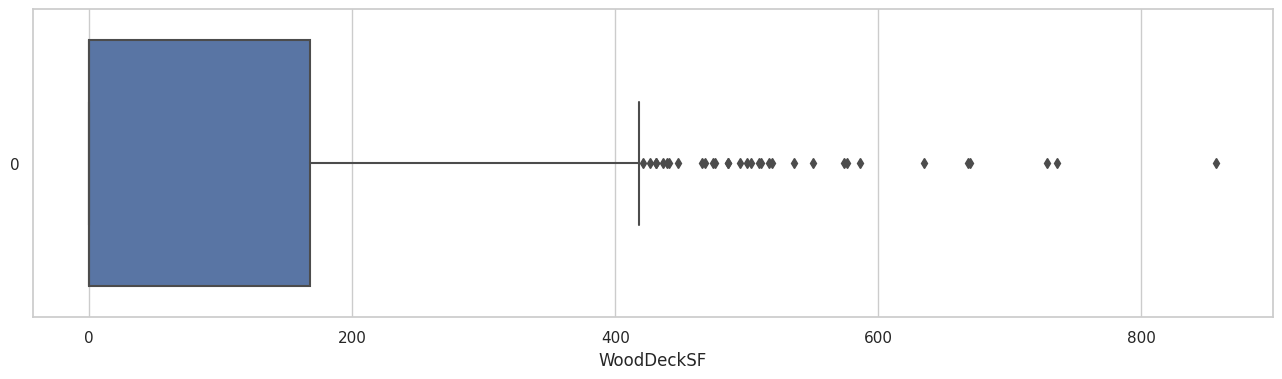

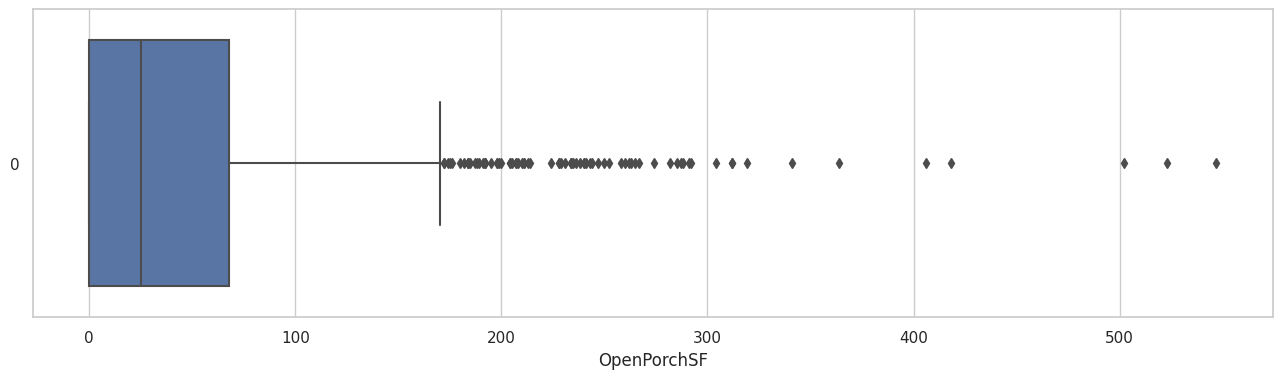

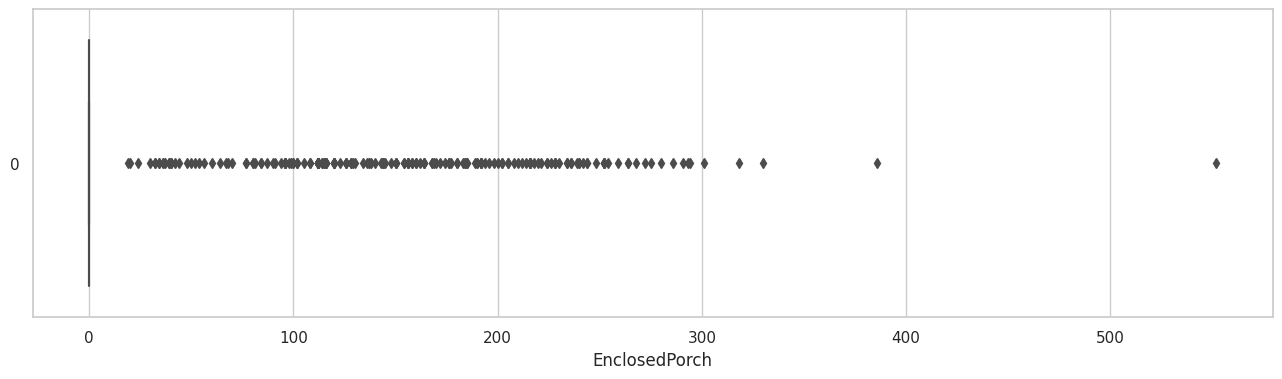

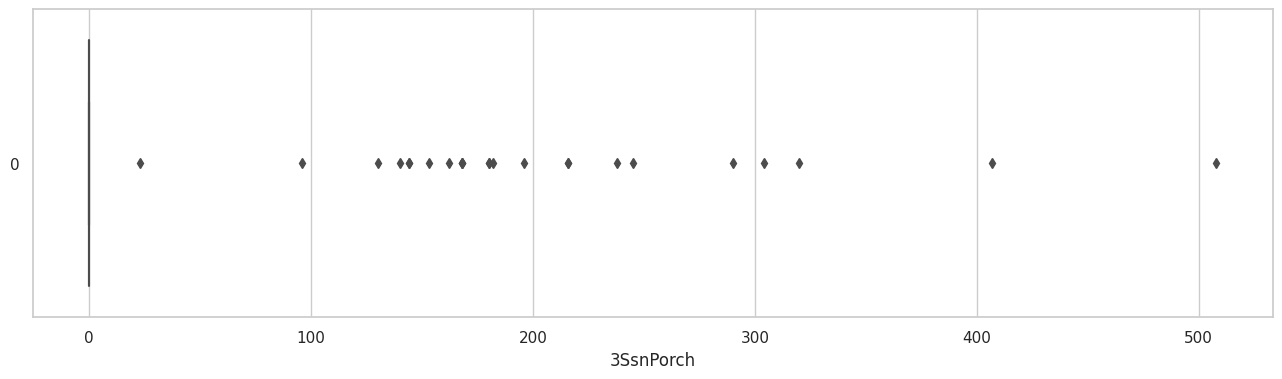

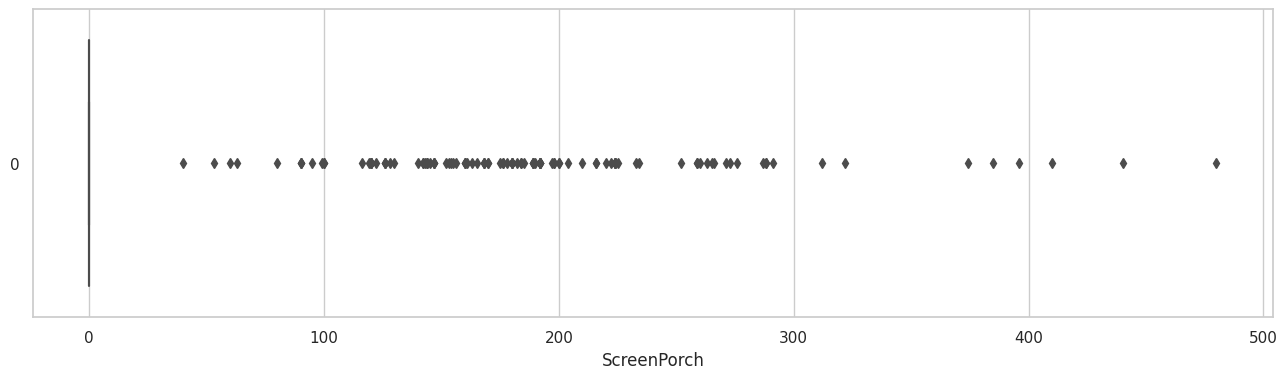

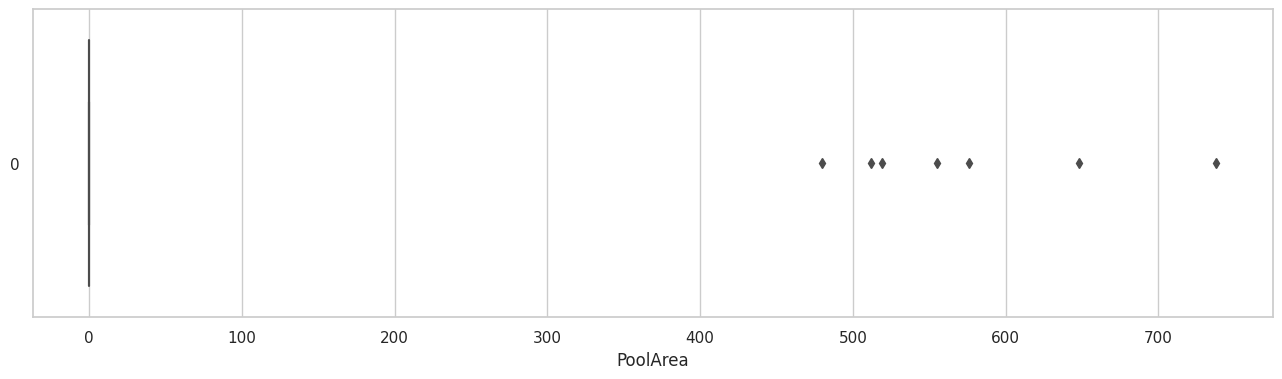

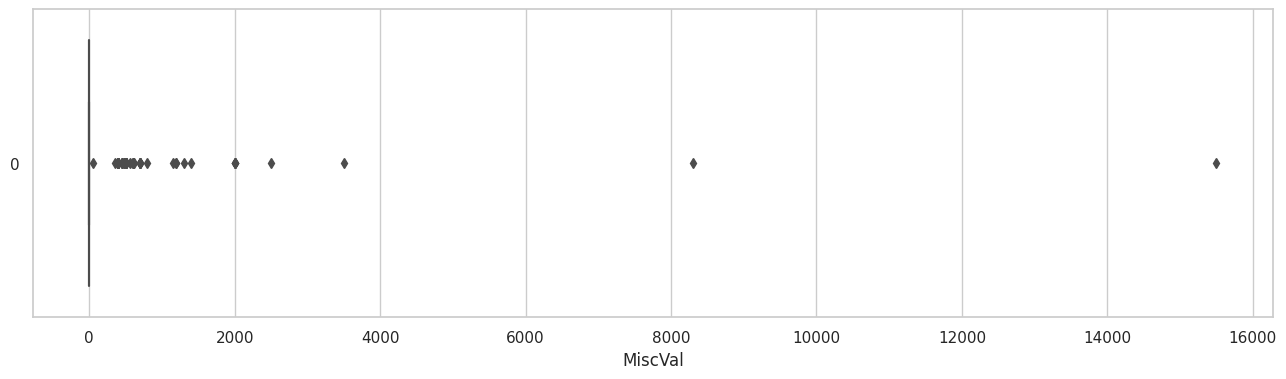

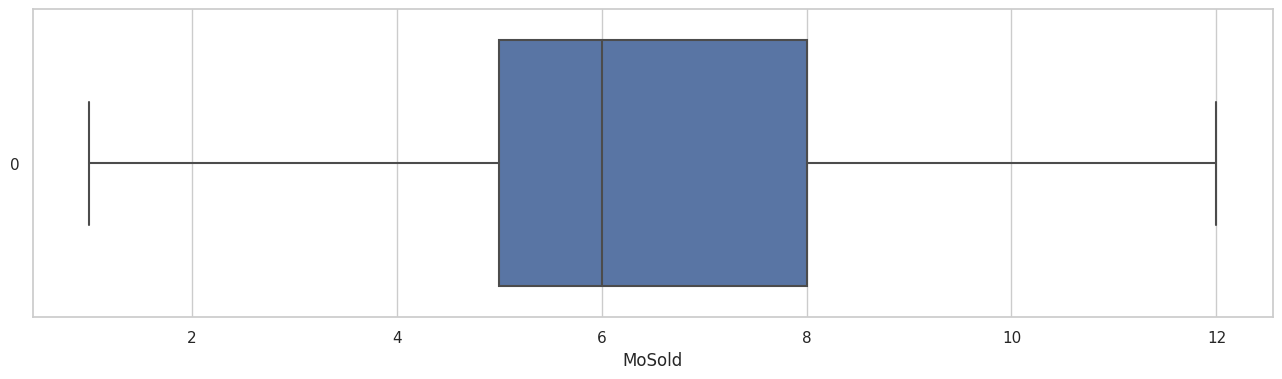

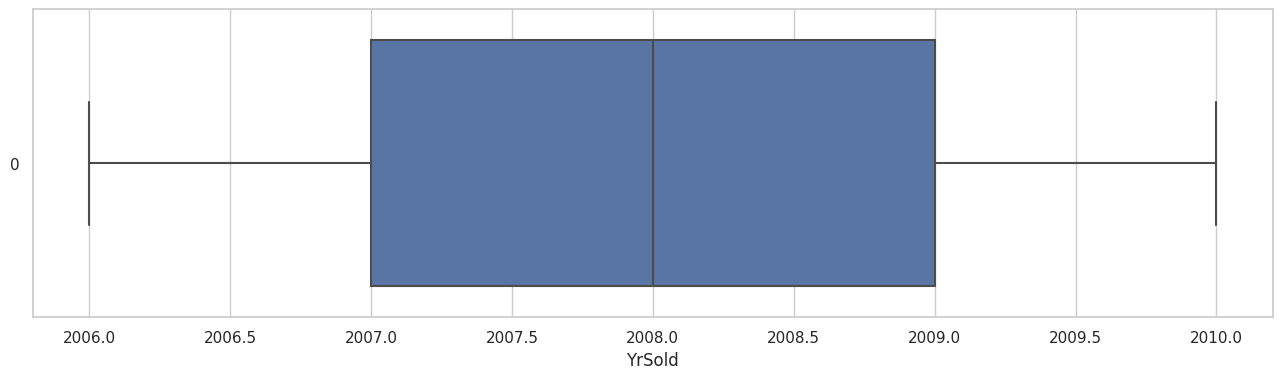

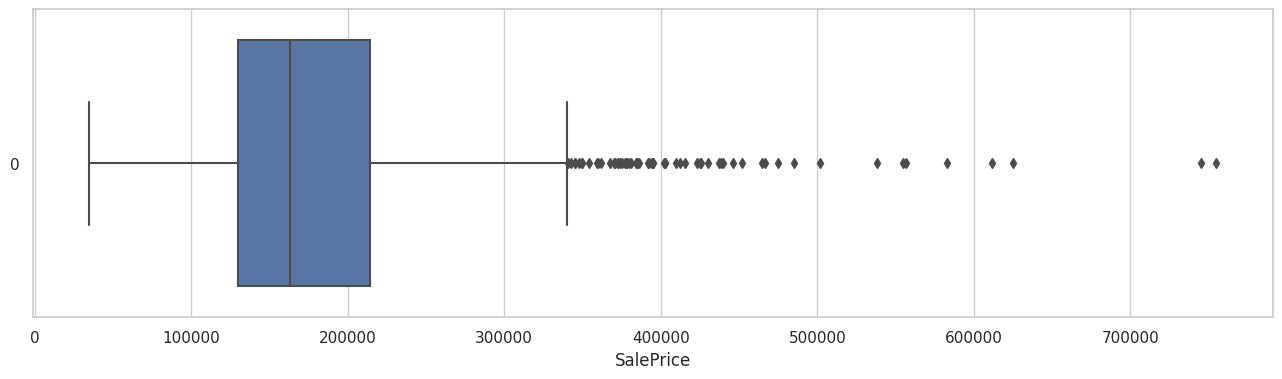

In [5]:
# Find outliers for all the numerical dataset

df_without_id = df_train.drop("Id",axis=1)
numerical_df = df_without_id.select_dtypes(exclude="object")

for column in numerical_df:
    plt.figure(figsize=(16,4))
    sns.set_theme(style="whitegrid")
    sns.boxplot(numerical_df[column], orient='h')
    plt.xlabel(column)

According the images above, we can see that there are outliers in the data. 
We will not delete the rows containing the outliers as the chances are it might destroy some important data. We will handle the outliers later using the cross-validation technique.


In [6]:
#features present in train data that are not present in test data
feature_train_not_test = [col for col in df_train.columns if col not in df_test.columns and col != 'SalePrice']

print(feature_train_not_test)

[]


**Observation**: Test data has all the features which are present in Train data (of course excluding the target feature ‘SalePrice’)

In [ ]:
feature_test_not_train = [col for col in df_test.columns if col not in df_train.columns]

print(feature_test_not_train)

**Observation**: Train data has all the features which are present in Test data

## Preprocessing

### Merge train and test data for data preprocessing

Instead of applying the data-preprocessing steps first on train data and then the same steps on test data, we will merge the two datasets then perform data preprocessing and feature encoding, and then split the data before building a model.


We will combine the two datasets row-wise and add an extra feature named ‘ind’ which can be used later while splitting the two datasets.


In [7]:
# Merge the datasets 
df = pd.concat([df_train.assign(ind='train'),df_test.assign(ind="test")])

# Reset the index 
df.reset_index(drop=True, inplace=True)

df.shape



(2919, 82)

### Handle categorical and numerical missing values

In [8]:
#Function to get count of missing values in each column

def get_cols_with_missing_values(DataFrame):
    missing_na_columns=(DataFrame.isnull().sum())
    return missing_na_columns[missing_na_columns > 0]
print(get_cols_with_missing_values(df))

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64


In [ ]:
# Find out missing rows

df.isnull().sum().sort_values(ascending=False).head(36)

### i. Impute missing categorical features

On exploring the ‘data_exploration.txt’ we can see that there are few features that contain features with rating or quality.

In [ ]:
# Get a list of all the categorical features that have the keyword 'Qual' OR 'Cond' OR 'Qu' OR 'QC' in the feature name
feature_rating_Qual = [col for col in df.columns if 'Qual' in col and df[col].dtypes=='object']
feature_rating_Cond = [col for col in df.columns if 'Cond' in col and col not in ['Condition1', 'Condition2', 'SaleCondition'] and df[col].dtypes=='object']
feature_rating_Qu = [col for col in df.columns if 'Qu' in col and df[col].dtypes=='object' and col not in feature_rating_Qual]
feature_rating_QC = [col for col in df.columns if 'QC' in col and df[col].dtypes=='object']

cat_feature_with_rating = feature_rating_Qual + feature_rating_Cond + feature_rating_Qu + feature_rating_QC
for x in cat_feature_with_rating:
    print(x)

In [ ]:
#Categorical features who have NA as a correct value

cat_feature_with_legit_na = ['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature']
df[cat_feature_with_legit_na].head()

In [ ]:
ordinal_cat_features = cat_feature_with_rating + cat_feature_with_legit_na
df[ordinal_cat_features].head()


We will handle the missing values in the ‘ordinal_cat_features’ by replacing the NAN value with the keyword ‘Missing’. We are doing so because having a missing value in these features makes sense. Eg — Having a **NaN** value in the feature ‘GarageType’ means that the house has no garage.

In [ ]:
#On checking the data description, Missing is valid in some categorical

#Handling Missing Values in Ordinal Categorical features by replacing them with 'Missing' keyword

df[ordinal_cat_features] = df[ordinal_cat_features].fillna("Missing")
#Making sure the missing values have been handled
print(get_cols_with_missing_values(df[ordinal_cat_features]))

We will replace the missing values in the remaining categorical features with the mode.

In [ ]:
categorical_cols=[cname for cname in df.columns if df[cname].dtypes=='object' and cname!='ind']
remaining_cat_cols = [cname for cname in categorical_cols if cname not in ordinal_cat_features]
#Handling Missing Values in Categorical features by replacing them with the feature mode value
for col in remaining_cat_cols:
     df[col] = df[col].fillna(df[col].mode()[0])

### ii. Impute missing numerical features

In [ ]:
#Handling Missing Values in Numerical features by replacing them with Mean value
numerical_cols=[cname for cname in df.columns if df[cname].dtypes!='object']
df[numerical_cols]=df[numerical_cols].fillna(df[numerical_cols].mean())

### Encodage

We will have to one-hot encode the non-ordinal categorical features , so we will choose only the features with **low** cardinality (number of unique values) <10

In [ ]:
# Select categorical columns with low cardinality
categorical_cols=[cname for cname in df.columns if df[cname].dtypes=='object' and df[cname].nunique()<10]

# Keep selected columns only
my_cols = numerical_cols + categorical_cols

df_clean = df[my_cols].copy()

### Feature Engineering

In [ ]:
# look up correlation between numeric features 

df_corr = df_clean.select_dtypes(exclude="object").corr().round(2)

# Create a heatmap 
plt.figure(figsize=(48,32))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt="0.2f",linewidths= 0.5, annot_kws = {"size":16})

In [ ]:
#Drop 'Id' feature
df_clean.drop('Id', axis=1, inplace=True)

Because some columns capture **year** information, we have the opportunity to engineer new features

Handling features with Year in it:

In [ ]:
df_clean['GarageYrBlt'] = df_clean['GarageYrBlt'].astype('int')
df_clean['GarageYrBlt'] = df_clean['YrSold'] - df_clean['GarageYrBlt']
df_clean['YearBuilt'] = df_clean['YrSold'] - df_clean['YearBuilt']
df_clean['YearRemodAdd'] = df_clean['YrSold'] - df_clean['YearRemodAdd']
df_clean.drop(["YrSold"], axis=1, inplace=True)
df_clean.drop(["MoSold"], axis=1, inplace=True)

Handling features with square footage:

In [ ]:
df_clean.drop(["TotalBsmtSF"], axis=1, inplace=True)
#Basement finished area
df_clean['BsmtFinSF'] = df_clean['BsmtFinSF1'] + df_clean['BsmtFinSF2']
df_clean.drop(["BsmtFinSF1"], axis=1, inplace=True)
df_clean.drop(["BsmtFinSF2"], axis=1, inplace=True)
#Total floor square feet
df_clean['TotalFlrSF'] = df_clean['1stFlrSF'] + df_clean['2ndFlrSF']

df_clean.drop(["1stFlrSF"], axis=1, inplace=True)
df_clean.drop(["2ndFlrSF"], axis=1, inplace=True)

Handling Bathroom features:

In [ ]:
df_clean['Total_Bath'] = (df_clean['FullBath'] 
        + (0.5*df_clean['HalfBath']) 
        + df_clean['BsmtFullBath'] 
        + (0.5*df_clean['BsmtHalfBath']))

# We remove these columns, because we used them to build a new feature
df_clean.drop(["FullBath"], axis=1, inplace=True)
df_clean.drop(["HalfBath"], axis=1, inplace=True)
df_clean.drop(["BsmtFullBath"], axis=1, inplace=True)
df_clean.drop(["BsmtHalfBath"], axis=1, inplace=True)

### Feature Transformation

In [ ]:
numerical_cols = [cname for cname in df_clean.columns if df_clean[cname].dtypes!='object' and cname!='SalePrice']
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df_clean[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

In [ ]:
df_clean[numerical_cols].describe()

There are few numerical features whose minimum value is 0. Here we are not able to apply log transformation. So we will apply **log1p** transformation.

In [ ]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    df_clean[column] = np.log1p(df_clean[column])
    


### Encode categorical features

In [ ]:
#Before encoding - features with rating
df_clean[cat_feature_with_rating]

In [ ]:
for col in cat_feature_with_rating:
    if 'Missing' in df_clean[col].value_counts().index:
        df_clean[col] = df_clean[col].map({"Missing":0,"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5})
    else:
        df_clean[col] = df_clean[col].map({"Po":1,"Fa":2,"TA":3,"Gd":4,"Ex":5})

In features where the missing value is applicable, we are mapping value ‘missing’: 0.
And the rest of the features are mapped as-
‘poor’: 1, ‘fair’: 2, ‘average’: 3, ‘good’:4, ‘excellent’: 5

In [ ]:
#After encoding - features with rating
df_clean[cat_feature_with_rating]

Now, we will encode the categorical features that have a valid missing value and follow an order.

In [ ]:
#features with legit na
df_clean[cat_feature_with_legit_na]

In [ ]:
#Exclude 'Alley', MiscFeature' and 'GarageType' feature as they are not ordinal
df_clean['BsmtExposure'] = df_clean['BsmtExposure'].map({"Missing":0,"No":1,"Mn":2,"Av":3,"Gd":4}).astype('int')
df_clean['BsmtFinType1'] = df_clean['BsmtFinType1'].map({"Missing":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}).astype('int')
df_clean['BsmtFinType2'] = df_clean['BsmtFinType2'].map({"Missing":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6}).astype('int')
df_clean['GarageFinish'] = df_clean['GarageFinish'].map({"Missing":0,"Unf":1,"RFn":2,"Fin":3}).astype('int')
df_clean['Fence'] = df_clean['Fence'].map({"Missing":0,"MnWw":1,"GdWo":2,"MnPrv":3,"GdPrv":4}).astype('int')

There are other features where rank can be applied-

In [ ]:
df_clean['LotShape'] = df_clean['LotShape'].map({"IR3":1,"IR2":2,"IR1":3,"Reg":4}).astype('int')
df_clean['LandContour'] = df_clean['LandContour'].map({"Low":1,"Bnk":2,"HLS":3,"Lvl":4}).astype('int')
df_clean['Utilities'] = df_clean['Utilities'].map({"ELO":1,"NoSeWa":2,"NoSewr":3,"AllPub":4}).astype('int')
df_clean['LandSlope'] = df_clean['LandSlope'].map({"Sev":1,"Mod":2,"Gtl":3}).astype('int')
df_clean['CentralAir'] = df_clean['CentralAir'].map({"N":0,"Y":1}).astype('int')
df_clean['PavedDrive'] = df_clean['PavedDrive'].map({"N":0,"P":1,"Y":2}).astype('int')

Now we will apply encoding on the remaining categorical features.

In [ ]:
cat_remaining_to_encode = [col for col in df_clean.columns if df_clean[col].dtypes=='object' and col !='ind']
print(cat_remaining_to_encode)

In [ ]:
df_clean_dummies = pd.get_dummies(df_clean[cat_remaining_to_encode],drop_first=True)
df_clean.drop(cat_remaining_to_encode,axis=1,inplace=True)
df_clean = pd.concat([df_clean,df_clean_dummies],axis=1)

### Split train and test data

In [ ]:
test, train= df_clean[df_clean["ind"].eq("test")], df_clean[df_clean["ind"].eq("train")]

test.drop(["SalePrice", "ind"], axis=1, inplace=True)

train.drop(["ind"], axis=1, inplace=True)

### Target feature encoding

As we saw above, we need to apply a log transformation on the target feature because its distribution is highly right-skewed, and taking the logarithm both stabilizes the variance and brings the data closer to a normal distribution, improving model fit and preserving the linear relationships with our predictors.

In [ ]:
log_target = np.log(train['SalePrice'])

train.drop(["SalePrice"], axis=1, inplace=True)

## Baseline Model

### Bagging Ensemble

In [ ]:
catboost_params = {
    'iterations': 5000,
    'learning_rate': 0.02,
    'depth': 4,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 20
}

xgboost_params = {
    'n_estimators': 5000,
    'learning_rate': 0.02,
    'colsample_bytree': 0.5,
    'subsample': 0.5,
    'min_child_weight': 2, 
}

I have used the Catboost and XGBoost algorithms to get the predictions. I have also modified the parameters manually to get a personal score.
Instead of manually tuning the hyperparameters, we can first use ‘RandomizedSearchCV’ to get a range of parameters and then use ‘GridSearchCV’ to get the best parameters.


In [ ]:
models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
    "xgb": XGBRegressor(**xgboost_params, verbose=0)
}

In [ ]:
catboost_model = CatBoostRegressor(**catboost_params, verbose=0)
xgb = XGBRegressor(**xgboost_params, verbosity=0)

In [ ]:
catboost_model.fit(train,log_target)

In [ ]:
xgb.fit(train,log_target)

We will use K Fold cross-validation on the train data (this will help us to deal with the outliers in numerical features we saw during the EDA)

In [ ]:
kf = KFold(n_splits=10)
catboost_rmse= np.exp(np.sqrt(-cross_val_score(catboost_model,train,log_target, scoring="neg_mean_squared_error", cv=kf)))

We take the square root with np.sqrt to obtain the RMSE (Root Mean Squared Error), then apply the exponential to revert back to the original scale after having log-transformed the target.

In [ ]:
xgb_rmse = np.exp(np.sqrt(-cross_val_score(xgb,train, log_target,scoring="neg_mean_squared_error", cv=kf )))

In [ ]:
print(np.mean(catboost_rmse))
print(np.mean(xgb_rmse))

In [ ]:
final_predictions = (0.8 * np.exp(catboost_model.predict(test)) + 0.2 * np.exp(xgb.predict(test)))

In [ ]:
# save test predictions to file 
output = pd.DataFrame({'Id': test.index+1,'SalePrice':final_predictions})
output.to_csv('submission.csv',index=False)

In [ ]:
output